In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torchvision.models import regnet_y_400mf
import zipfile
from google.colab import files
import os

# **Importer le dataset**

In [2]:
uploaded = files.upload()
zip_path = "/content/data_2.zip"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content/dossier_extrait_2")

# Vérifiez le contenu extrait
os.listdir("/content/dossier_extrait_2")

Saving data_2.zip to data_2 (1).zip


['data_2']

In [3]:
# Paramètres
from torchvision import datasets
num_classes = 4
batch_size = 64
data_dir = "/content/dossier_extrait_2/data_2"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Définition des transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Chargement des données
trainset = datasets.ImageFolder(root=os.path.join(data_dir, "Train"), transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = datasets.ImageFolder(root=os.path.join(data_dir, "Test"), transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

# Récupérer les noms des classes
classes = trainset.classes



# **RegNet-400mf**

In [4]:
# Chargement du modèle RegNet
model = regnet_y_400mf(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)  # Adapter à 4 classes
model = model.to(device)

# Définition de la fonction de perte et de l'optimiseur
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


# **Training**

In [5]:
# Ajustement du learning rate
def adjust_learning_rate(optimizer, epoch):
    lr = 0.01 if epoch >= 80 else 0.1
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

# Entraînement
num_epochs = 150
for epoch in range(num_epochs):
    model.train()
    adjust_learning_rate(optimizer, epoch)
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch+1}/{num_epochs}, Accuracy: {accuracy:.2f}%, Loss: {running_loss/len(trainloader):.4f}, Lr: {current_lr:.6f}")

print("Entraînement terminé !")

model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Précision sur le test: {100 * correct / total:.2f}%')

Epoch 1/150, Accuracy: 32.18%, Loss: 8.8277, Lr: 0.100000
Epoch 2/150, Accuracy: 49.43%, Loss: 22.1749, Lr: 0.100000
Epoch 3/150, Accuracy: 45.98%, Loss: 9.4001, Lr: 0.100000
Epoch 4/150, Accuracy: 26.44%, Loss: 1.5577, Lr: 0.100000
Epoch 5/150, Accuracy: 34.48%, Loss: 3.6854, Lr: 0.100000
Epoch 6/150, Accuracy: 35.63%, Loss: 1.5790, Lr: 0.100000
Epoch 7/150, Accuracy: 32.18%, Loss: 5.6477, Lr: 0.100000
Epoch 8/150, Accuracy: 47.13%, Loss: 4.0687, Lr: 0.100000
Epoch 9/150, Accuracy: 48.28%, Loss: 4.4219, Lr: 0.100000
Epoch 10/150, Accuracy: 49.43%, Loss: 1.1031, Lr: 0.100000
Epoch 11/150, Accuracy: 49.43%, Loss: 6.1059, Lr: 0.100000
Epoch 12/150, Accuracy: 49.43%, Loss: 1.1672, Lr: 0.100000
Epoch 13/150, Accuracy: 49.43%, Loss: 5.4389, Lr: 0.100000
Epoch 14/150, Accuracy: 48.28%, Loss: 3.1593, Lr: 0.100000
Epoch 15/150, Accuracy: 48.28%, Loss: 4.5120, Lr: 0.100000
Epoch 16/150, Accuracy: 50.57%, Loss: 2.2731, Lr: 0.100000
Epoch 17/150, Accuracy: 31.03%, Loss: 3.1284, Lr: 0.100000
Epoch

# **Affichage Predictions**

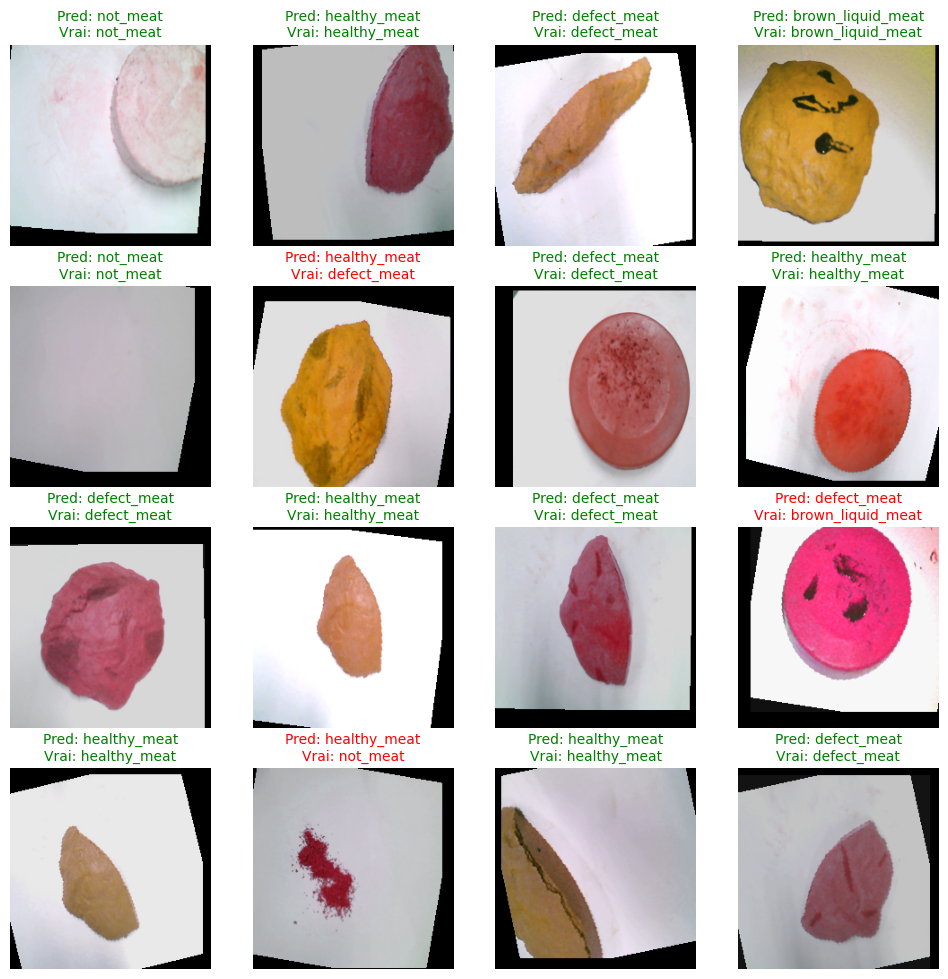

In [7]:
all_images = []
all_labels = []
for images, labels in testloader:
    all_images.append(images)
    all_labels.append(labels)
all_images = torch.cat(all_images, dim=0)
all_labels = torch.cat(all_labels, dim=0)
random_indices = random.sample(range(len(all_images)), 16)
random_images = all_images[random_indices].to(device)
random_labels = all_labels[random_indices].to(device)
outputs = model(random_images)
_, predicted = torch.max(outputs, 1)
random_images = random_images.cpu()
predicted = predicted.cpu()
random_labels = random_labels.cpu()
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
for i, ax in enumerate(axes.flat):
    title = f"Pred: {classes[predicted[i]]}\nVrai: {classes[random_labels[i]]}"
    ax.imshow(np.transpose((random_images[i] / 2 + 0.5).numpy(), (1, 2, 0)))
    ax.set_title(title, fontsize=10, color='green' if predicted[i] == random_labels[i] else 'red')
    ax.axis('off')
plt.show()